# Enhanced Sentiment Analyser : Using Stacked Ensemble Learning (Amazon Reviews Dataset)
We use four tools namely BERT, VADER, Textblob and Flair to give sentiment scores all of which are fed to a Logistic Regressor First.

## Basic Data Loading and Checking the Base Models or Tools

In [4]:
!pip install pandas

In [5]:
!pip install textblob

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import textblob
from scipy.spatial.distance import cdist
import seaborn as sns
import nltk
import sklearn.metrics
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve


/Users/amitobe/opt/anaconda3/envs/nlp_course/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [5]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [6]:
from textblob import TextBlob

In [7]:
newsheadline_corr_analysis  = pd.read_csv('amazon_reviews.csv').sample(10000)

#newsheadline_corr_analysis  = pd.read_csv('amazon_test.csv').sample(2000)



In [8]:
# Assuming you have a dataset 'original_data' with a 'class' column
class_0_data = newsheadline_corr_analysis[newsheadline_corr_analysis['sentiment'] == -1]
class_1_data = newsheadline_corr_analysis[newsheadline_corr_analysis['sentiment'] == 1]

# Calculate the size of the balanced sample for each class
sample_size_per_class = 1000

# Randomly sample data from each class
sampled_class_0 = class_0_data.sample(n=sample_size_per_class, random_state=42)
sampled_class_1 = class_1_data.sample(n=sample_size_per_class, random_state=42)

# Combine the sampled data to create the balanced sample
balanced_sample = pd.concat([sampled_class_0, sampled_class_1])

# Shuffle the balanced sample
balanced_sample = balanced_sample.sample(frac=1, random_state=42).reset_index(drop=True)


In [9]:
newsheadline_corr_analysis.head()

,Unnamed: 0,sentiment,review
2724834,2724834,-1,"It made good toast, but was slow (over five mi..."
823043,823043,1,This album is very much underrated. Some excel...
1968027,1968027,1,I bought this dvd set for my husband because h...
3064642,3064642,1,The refurbished Klipsch igroove HG all in one ...
384642,384642,1,"My first review of this item was not good, how..."


In [10]:
newsheadline_corr_analysis.to_csv('amazon_test.csv')

In [11]:
newsheadline_corr_analysis.rename(columns={'review':'Headline','sentiment':'Sentiment'},inplace = True  )

In [12]:
import seaborn as sns
import matplotlib

### About Flair

FLAIR Tagging -  language model (in yellow) and the sequence tagging (labeling) model (in blue). The bidirectional character language model receives the original text as input and computes contextual embeddings for each word. These are then passed into a BiLSTM-CRF sequence labeler. This special type of labeler makes use of a bidirectional LSTM (BiLSTM) recurrent neural model combined with a Conditional Random Field (CRF) – a type of combinatorial algorithm. It outputs the probability distribution of labels corresponding to individual words. The most probable label is then chosen for each word (as seen in the preceding figure in the top row). For example, the word Washington is labeled as E-PER in the preceding
figure, where PER suggests the word relates to a person and E marks the ending of a two-word named entity chunk. Words are often also tagged with a special label, O (meaning other), used for words not considered named entities or named entities belonging to none of the defined categories.
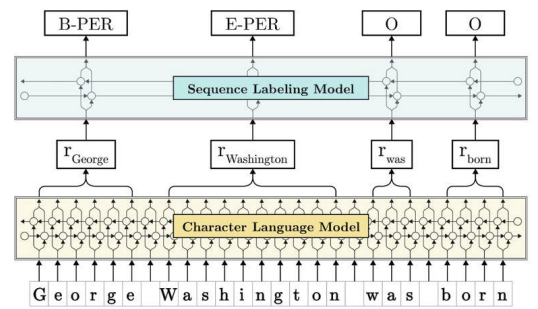

In [13]:
import flair

In [14]:
flair_model = flair.models.TextClassifier.load('en-sentiment')
def process_flair(dialogue):   # returning the flair score
    sentence = flair.data.Sentence(dialogue)
    flair_model.predict(sentence)
    label = sentence.labels[0].value
    score = sentence.labels[0].score
    if label == 'POSITIVE':
        return score
    elif label == 'NEGATIVE':
        return -score

In [3]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from scipy.special import softmax

MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
bert_model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [32]:
def return_sentiment(txt):  # returning single-sentence BERT score
    encoded_input = tokenizer(txt, return_tensors='pt',padding=True,truncation=True)
    output = bert_model(**encoded_input)
    score = output[0][0].detach().numpy() 
    scores = softmax(score)
    if np.argsort(scores)[2] == 1: # this is the highest score
        return 0 #this is neutral
    else:
        return (np.argsort(scores)[2]-1)*scores[np.argsort(scores)[2]] #converts prob to + or - polarities

In [29]:
encoded_input = tokenizer("I dont love this Ice Cream", return_tensors='pt',padding=True,truncation=True)

In [30]:
output = bert_model(**encoded_input)

In [31]:
np.argmax(softmax(output[0][0].detach().numpy()))

0

In [1]:
def cal_vader_textblob_bert_flair(txt):
    tb_score = TextBlob(txt).sentiment.polarity
    obj = SentimentIntensityAnalyzer()
    vader_score = obj.polarity_scores(txt)['compound']
    flair_score = process_flair(txt)
    bert_score = return_sentiment(txt)
    #prob = logmodel3.predict_proba([[tb_score,vader_score,flair_score,bert_score]])[0]      
    return pd.Series({'vader':vader_score,'textblob': tb_score,'bert':bert_score,'flair':flair_score})


In [18]:
def tb_score(txt):
    sen = TextBlob(txt)
    return pd.Series({'tb': sen.sentiment.polarity})

In [19]:

newsheadline_corr_analysis.head()

,Unnamed: 0,Sentiment,Headline
2724834,2724834,-1,"It made good toast, but was slow (over five mi..."
823043,823043,1,This album is very much underrated. Some excel...
1968027,1968027,1,I bought this dvd set for my husband because h...
3064642,3064642,1,The refurbished Klipsch igroove HG all in one ...
384642,384642,1,"My first review of this item was not good, how..."


In [20]:
newsheadline_corr_analysis['Sentiment'].astype(float)

2724834   -1.0
823043     1.0
1968027    1.0
3064642    1.0
384642     1.0
          ... 
3463364   -1.0
2609640    1.0
3598229   -1.0
994136     1.0
3043880    1.0
Name: Sentiment, Length: 10000, dtype: float64

In [21]:
newsheadline_corr_analysis['Sentiment'].value_counts(dropna=True)

 1    5001
-1    4999
Name: Sentiment, dtype: int64

In [22]:
#newsheadline_corr_analysis = pd.concat([newsheadline_corr_analysis, newsheadline_corr_analysis['Headline'].apply(cal_vader_textblob_bert_flair)], axis=1)

In [23]:
#newsheadline_corr_analysis.to_csv('amazon_test_results.csv')
newsheadline_corr_analysis = pd.read_csv('amazon_test_results.csv')

In [24]:
newsheadline_corr_analysis.head()

,Unnamed: 0,Unnamed: 0.1,Sentiment,Headline,vader,textblob,bert,flair
0,377936,377936,-1,The movie Le Bambole is quite an interesting p...,0.3005,0.140000,-0.545708,-0.999974
1,681864,681864,1,"Like other reviewers, I first caught The Ice H...",0.9396,0.342500,0.967779,0.999746
2,2730859,2730859,-1,I am very disappointed in this kit. The outsid...,0.9235,0.162037,-0.910500,-0.999998
3,1599595,1599595,-1,The shipping was as much as the item and the i...,-0.0541,0.113889,-0.889409,-0.999972
4,1921536,1921536,1,Needed to add USB card for added bandwidth nec...,0.6249,0.300000,0.855487,0.998260


In [25]:
newsheadline_corr_analysis['Sentiment'].astype(float)

0      -1.0
1       1.0
2      -1.0
3      -1.0
4       1.0
       ... 
1995    1.0
1996   -1.0
1997   -1.0
1998   -1.0
1999   -1.0
Name: Sentiment, Length: 2000, dtype: float64

In [26]:
newsheadline_corr_analysis['Sentiment'].value_counts()


 1    1014
-1     986
Name: Sentiment, dtype: int64

def senti_adjust(score):
    if score == 0:
        return float(-1.0)
    else:
        return float(1.0)

In [27]:
float(1)

1.0

In [28]:
#newsheadline_corr_analysis['Sentiment'] = newsheadline_corr_analysis.apply(lambda x: senti_adjust(x['Sentiment']), axis=1)

In [29]:
newsheadline_corr_analysis['Sentiment'].astype(float)

0      -1.0
1       1.0
2      -1.0
3      -1.0
4       1.0
       ... 
1995    1.0
1996   -1.0
1997   -1.0
1998   -1.0
1999   -1.0
Name: Sentiment, Length: 2000, dtype: float64

In [30]:
#newsheadline_corr_analysis.to_csv('amazon_test_results.csv')

In [31]:
def polarity(val):
    if val >= 0:
        return 1
    else:
        return -1
    
    

(array([515., 205.,  88.,   5., 198.,   0.,  14.,  94., 134., 747.]),
 array([-0.96446502, -0.76907454, -0.57368405, -0.37829356, -0.18290308,
         0.01248741,  0.2078779 ,  0.40326838,  0.59865887,  0.79404936,
         0.98943985]),
 <a list of 10 Patch objects>)

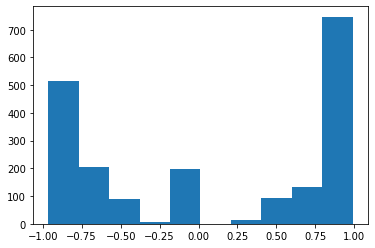

In [32]:
plt.hist(newsheadline_corr_analysis['bert'])


In [33]:
newsheadline_corr_analysis[['bert','vader','textblob','flair','Sentiment']].corr()

,bert,vader,textblob,flair,Sentiment
bert,1.000000,0.625384,0.599022,0.811486,0.793903
vader,0.625384,1.000000,0.577443,0.510042,0.495085
textblob,0.599022,0.577443,1.000000,0.517864,0.499081
flair,0.811486,0.510042,0.517864,1.000000,0.869075
Sentiment,0.793903,0.495085,0.499081,0.869075,1.000000


In [34]:
newsheadline_corr_analysis['vader_polarity'] = newsheadline_corr_analysis.apply(lambda x: polarity(x['vader']), axis=1)
newsheadline_corr_analysis['textblob_polarity'] = newsheadline_corr_analysis.apply(lambda x: polarity(x['textblob']), axis=1)
newsheadline_corr_analysis['bert_polarity'] = newsheadline_corr_analysis.apply(lambda x: polarity(x['bert']), axis=1)
newsheadline_corr_analysis['flair_polarity'] = newsheadline_corr_analysis.apply(lambda x: polarity(x['flair']), axis=1)

In [35]:
newsheadline_corr_analysis[['bert_polarity','vader_polarity','textblob_polarity','flair_polarity','Sentiment']].corr()

,bert_polarity,vader_polarity,textblob_polarity,flair_polarity,Sentiment
bert_polarity,1.000000,0.512275,0.442117,0.721308,0.725245
vader_polarity,0.512275,1.000000,0.490160,0.433013,0.419939
textblob_polarity,0.442117,0.490160,1.000000,0.363512,0.371276
flair_polarity,0.721308,0.433013,0.363512,1.000000,0.858215
Sentiment,0.725245,0.419939,0.371276,0.858215,1.000000


In [36]:
newsheadline_corr_analysis.head()

,Unnamed: 0,Unnamed: 0.1,Sentiment,Headline,vader,textblob,bert,flair,vader_polarity,textblob_polarity,bert_polarity,flair_polarity
0,377936,377936,-1,The movie Le Bambole is quite an interesting p...,0.3005,0.140000,-0.545708,-0.999974,1,1,-1,-1
1,681864,681864,1,"Like other reviewers, I first caught The Ice H...",0.9396,0.342500,0.967779,0.999746,1,1,1,1
2,2730859,2730859,-1,I am very disappointed in this kit. The outsid...,0.9235,0.162037,-0.910500,-0.999998,1,1,-1,-1
3,1599595,1599595,-1,The shipping was as much as the item and the i...,-0.0541,0.113889,-0.889409,-0.999972,-1,1,-1,-1
4,1921536,1921536,1,Needed to add USB card for added bandwidth nec...,0.6249,0.300000,0.855487,0.998260,1,1,1,1


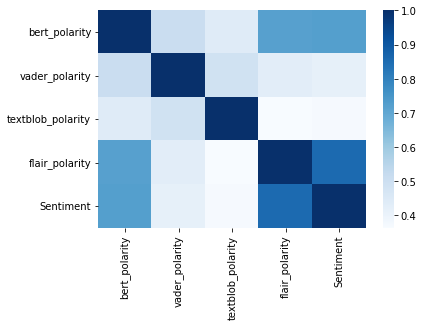

In [37]:
cordata = pd.DataFrame(newsheadline_corr_analysis[['bert_polarity','vader_polarity','textblob_polarity','flair_polarity','Sentiment']].corr())
cordata.to_csv('corrdata_amazon.csv')
sns.heatmap (cordata,cmap='Blues')

In [38]:
cordata.head()

,bert_polarity,vader_polarity,textblob_polarity,flair_polarity,Sentiment
bert_polarity,1.000000,0.512275,0.442117,0.721308,0.725245
vader_polarity,0.512275,1.000000,0.490160,0.433013,0.419939
textblob_polarity,0.442117,0.490160,1.000000,0.363512,0.371276
flair_polarity,0.721308,0.433013,0.363512,1.000000,0.858215
Sentiment,0.725245,0.419939,0.371276,0.858215,1.000000


In [39]:
newsheadline_corr_analysis = newsheadline_corr_analysis[(newsheadline_corr_analysis['vader'] != 0) |
                   (newsheadline_corr_analysis['textblob'] != 0) |
                   (newsheadline_corr_analysis['bert'] != 0) |
                   (newsheadline_corr_analysis['flair'] != 0) ]



In [40]:
newsheadline_corr_analysis[['vader','textblob','bert','flair','Sentiment']].corr()




,vader,textblob,bert,flair,Sentiment
vader,1.000000,0.577443,0.625384,0.510042,0.495085
textblob,0.577443,1.000000,0.599022,0.517864,0.499081
bert,0.625384,0.599022,1.000000,0.811486,0.793903
flair,0.510042,0.517864,0.811486,1.000000,0.869075
Sentiment,0.495085,0.499081,0.793903,0.869075,1.000000


In [41]:
newsheadline_corr_analysis.head()

,Unnamed: 0,Unnamed: 0.1,Sentiment,Headline,vader,textblob,bert,flair,vader_polarity,textblob_polarity,bert_polarity,flair_polarity
0,377936,377936,-1,The movie Le Bambole is quite an interesting p...,0.3005,0.140000,-0.545708,-0.999974,1,1,-1,-1
1,681864,681864,1,"Like other reviewers, I first caught The Ice H...",0.9396,0.342500,0.967779,0.999746,1,1,1,1
2,2730859,2730859,-1,I am very disappointed in this kit. The outsid...,0.9235,0.162037,-0.910500,-0.999998,1,1,-1,-1
3,1599595,1599595,-1,The shipping was as much as the item and the i...,-0.0541,0.113889,-0.889409,-0.999972,-1,1,-1,-1
4,1921536,1921536,1,Needed to add USB card for added bandwidth nec...,0.6249,0.300000,0.855487,0.998260,1,1,1,1


In [42]:
from sklearn import metrics
from sklearn.metrics import classification_report

#


### Vader

              precision    recall  f1-score   support

          -1       0.84      0.45      0.59       986
           1       0.63      0.92      0.75      1014

    accuracy                           0.69      2000
   macro avg       0.74      0.69      0.67      2000
weighted avg       0.74      0.69      0.67      2000



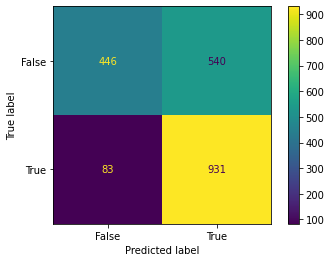

In [43]:
print(classification_report(newsheadline_corr_analysis['Sentiment'],newsheadline_corr_analysis['vader_polarity'])) # 
confusion_matrix_vader = metrics.confusion_matrix(newsheadline_corr_analysis['Sentiment'], newsheadline_corr_analysis['vader_polarity'])
cm_bert = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_vader, display_labels = [False, True])
cm_bert.plot()
plt.show()

### Textblob

              precision    recall  f1-score   support

          -1       0.86      0.36      0.50       986
           1       0.60      0.94      0.73      1014

    accuracy                           0.65      2000
   macro avg       0.73      0.65      0.62      2000
weighted avg       0.73      0.65      0.62      2000



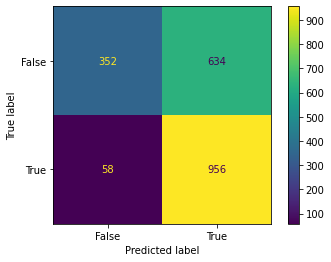

In [44]:
print(classification_report(newsheadline_corr_analysis['Sentiment'],newsheadline_corr_analysis['textblob_polarity'])) # 
confusion_matrix_tb = metrics.confusion_matrix(newsheadline_corr_analysis['Sentiment'], newsheadline_corr_analysis['textblob_polarity'])
cm_tb = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_tb, display_labels = [False, True])
cm_tb.plot()
plt.show()

### Bert

              precision    recall  f1-score   support

          -1       0.93      0.77      0.84       986
           1       0.81      0.94      0.87      1014

    accuracy                           0.86      2000
   macro avg       0.87      0.86      0.86      2000
weighted avg       0.87      0.86      0.86      2000



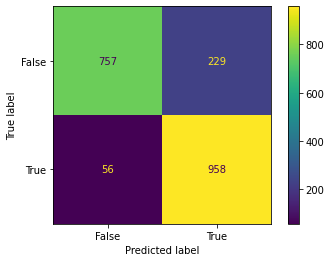

In [45]:
print(classification_report(newsheadline_corr_analysis['Sentiment'],newsheadline_corr_analysis['bert_polarity'])) # 
confusion_matrix_bert = metrics.confusion_matrix(newsheadline_corr_analysis['Sentiment'], newsheadline_corr_analysis['bert_polarity'])
cm_bert = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_bert, display_labels = [False, True])
cm_bert.plot()
plt.show()

### Flair

              precision    recall  f1-score   support

          -1       0.90      0.96      0.93       986
           1       0.96      0.89      0.93      1014

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000



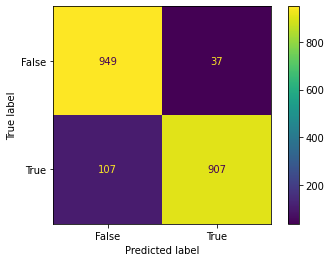

In [46]:
print(classification_report(newsheadline_corr_analysis['Sentiment'],newsheadline_corr_analysis['flair_polarity'])) # 
confusion_matrix_flair = metrics.confusion_matrix(newsheadline_corr_analysis['Sentiment'], newsheadline_corr_analysis['flair_polarity'])
cm_flair = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_flair, display_labels = [False, True])
cm_flair.plot()
plt.show()

### Data analysis

In [47]:

newsheadline_corr_analysis.head()



,Unnamed: 0,Unnamed: 0.1,Sentiment,Headline,vader,textblob,bert,flair,vader_polarity,textblob_polarity,bert_polarity,flair_polarity
0,377936,377936,-1,The movie Le Bambole is quite an interesting p...,0.3005,0.140000,-0.545708,-0.999974,1,1,-1,-1
1,681864,681864,1,"Like other reviewers, I first caught The Ice H...",0.9396,0.342500,0.967779,0.999746,1,1,1,1
2,2730859,2730859,-1,I am very disappointed in this kit. The outsid...,0.9235,0.162037,-0.910500,-0.999998,1,1,-1,-1
3,1599595,1599595,-1,The shipping was as much as the item and the i...,-0.0541,0.113889,-0.889409,-0.999972,-1,1,-1,-1
4,1921536,1921536,1,Needed to add USB card for added bandwidth nec...,0.6249,0.300000,0.855487,0.998260,1,1,1,1


In [48]:
newsheadline_corr_analysis['Sentiment'].value_counts()
## This is a skewed dataset
# Therefore Precision - Recall curve will be bette than the ROC curve in this case

 1    1014
-1     986
Name: Sentiment, dtype: int64

(array([ 986.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1014.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

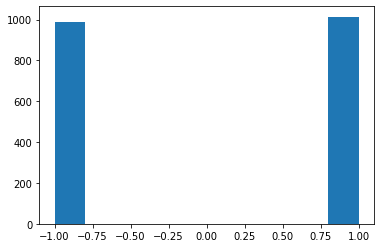

In [49]:
plt.hist(newsheadline_corr_analysis['Sentiment'])

## Training and Testing using Logistic Regressor

### Training and Checking 

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler


In [51]:
mmscaler = MinMaxScaler()

In [52]:
logmodel = LogisticRegression()


In [53]:

our_data=newsheadline_corr_analysis



In [54]:
X = our_data[['textblob','vader','bert','flair','vader_polarity','textblob_polarity','bert_polarity','flair_polarity','Sentiment']]
y = our_data['Sentiment']

In [55]:
from sklearn.model_selection import train_test_split

In [56]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

In [57]:
y_test.shape



(600,)

In [58]:
X_train

,textblob,vader,bert,flair,vader_polarity,textblob_polarity,bert_polarity,flair_polarity,Sentiment
498,0.257114,0.9572,0.958878,0.999993,1,1,1,1,1
749,0.088889,0.8225,0.581096,0.999918,1,1,1,1,1
1436,0.155069,0.8181,0.968198,0.999845,1,1,1,1,1
116,0.550000,0.8255,0.987808,0.998033,1,1,1,1,1
165,0.200000,0.4203,-0.695962,-0.999980,1,1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...
547,0.277500,0.9014,-0.529161,0.999967,1,1,-1,1,1
795,0.475000,0.9693,0.911618,0.999829,1,1,1,1,1
206,0.086824,0.0181,0.596046,-0.999992,1,1,1,-1,-1
763,0.322500,0.9110,0.826410,0.999149,1,1,1,1,1


In [59]:
X_train_full = X_train
X_train = X_train [['vader','textblob','bert','flair']]
X_train = mmscaler.fit_transform(X_train)

In [60]:
X_test_full = X_test
X_test = X_test [['vader','textblob','bert','flair']]
X_test = mmscaler.fit_transform(X_test)


In [61]:


logmodel.fit(X_train,y_train) # Outputs are -1 and 1

LogisticRegression()

In [62]:
X_train

array([[9.79800537e-01, 6.28556985e-01, 9.84547016e-01, 9.99998391e-01],
       [9.11608363e-01, 5.44444444e-01, 7.90747210e-01, 9.99961018e-01],
       [9.09380854e-01, 5.77534271e-01, 9.89328154e-01, 9.99924242e-01],
       ...,
       [5.04379082e-01, 5.43411797e-01, 7.98416783e-01, 3.57628572e-06],
       [9.56411684e-01, 6.61250000e-01, 9.16591993e-01, 9.99576508e-01],
       [8.49744343e-01, 6.88888889e-01, 9.50989003e-01, 9.96871584e-01]])

In [63]:
predictions = logmodel.predict(X_train)
probs = logmodel.predict_proba(X_train)


In [64]:
xx =pd.DataFrame([{'vader':.8,'textblob':.4,'bert':.8,'flair':.62}])
tem = logmodel.predict_proba(xx)
tem



/Users/amitobe/opt/anaconda3/envs/nlp_course/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


array([[0.18576849, 0.81423151]])

In [65]:
probs.shape




(1400, 2)

In [66]:

probsdf = pd.DataFrame(probs)
probsdf['trth'] = y_train.to_numpy()
#aplha = 0.80
#high_prob_data = probsdf[(probsdf[1] > aplha) | (probsdf[0] > aplha)]
#probsdf = high_prob_data
probsdf.shape


(1400, 3)

### ROC Curve Analysis

In [67]:
import matplotlib
import matplotlib.pyplot as pyplot

Logistic: ROC AUC=0.974


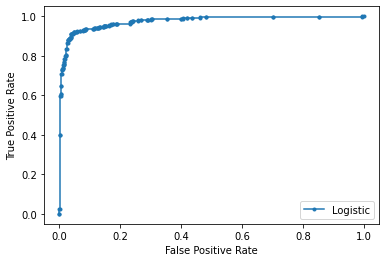

In [68]:
lr_probs = probs[:,[1]]
lr_auc = roc_auc_score(y_train, lr_probs)
# summarize scores

print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves

lr_fpr, lr_tpr, thr = roc_curve(y_train, lr_probs)
# plot the roc curve for the model # pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [69]:
optimal_idx = np.argmax(lr_tpr - lr_fpr) #we need to maximise TP-FP
thr[optimal_idx]

0.42381004503526565

In [70]:
alpha_thresh = thr[optimal_idx]

def label_pol (prob_score):
    
    if prob_score[1] > alpha_thresh:
        return 1
    else:
       return -1


In [71]:
probsdf['label_pol_pred'] = probsdf.apply (lambda row: label_pol(row), axis=1)
probsdf.head()



,0,1,trth,label_pol_pred
0,0.023532,0.976468,1,1
1,0.044228,0.955772,1,1
2,0.024322,0.975678,1,1
3,0.020310,0.979690,1,1
4,0.942476,0.057524,-1,-1


In [72]:
from sklearn import metrics
print(pd.DataFrame(metrics.classification_report(probsdf['trth'],probsdf['label_pol_pred'],output_dict=True)))




                   -1           1  accuracy    macro avg  weighted avg
precision    0.919178    0.953731  0.935714     0.936455      0.936405
recall       0.955840    0.915473  0.935714     0.935657      0.935714
f1-score     0.937151    0.934211  0.935714     0.935681      0.935685
support    702.000000  698.000000  0.935714  1400.000000   1400.000000



### Data Capture Threshold Analysis

In [73]:
threshold_analysis = pd.DataFrame({'Thresh_alpha':[0],'Accuracy':[0],'Percent_data_capture':[0],'Precision':[0],'Recall':[0],'f1':[0]})
detl_threshold = pd.DataFrame({'Thresh_alpha':[],'Accuracy':[],'Percent_data_capture':[],'Precision':[],'Recall':[],'f1':[]})
for i in range (4,92):
    alpha_th = i*.01
    res1 = pd.DataFrame(classification_report(probsdf['trth'][(probsdf[1]>alpha_th)|(probsdf[0]>alpha_th)],probsdf['label_pol_pred'][(probsdf[1]>alpha_th)|(probsdf[0]>alpha_th)],output_dict=True))
    try:
        res1 = pd.DataFrame(classification_report(probsdf['trth'][(probsdf[1]>alpha_th)|(probsdf[0]>alpha_th)],probsdf['label_pol_pred'][(probsdf[1]>alpha_th)|(probsdf[0]>alpha_th)],output_dict=True))
        threshold_analysis['Accuracy']= res1['accuracy'].iloc[0]        
    except KeyError:
        threshold_analysis['Accuracy']= 0
    try:
        threshold_analysis['Percent_data_capture'] = probsdf['trth'][(probsdf[1]>alpha_th)|(probsdf[0]>alpha_th)].count()/probsdf['trth'].count()
        threshold_analysis['Thresh_alpha'] = alpha_th
        threshold_analysis['Precision'] = res1['1'].loc['precision']
        threshold_analysis['Recall'] = res1['1'].loc['recall']
        threshold_analysis['f1'] = res1['1'].loc['f1-score']
    except KeyError:
        threshold_analysis['Precision'] = 0
        threshold_analysis['Recall'] = 0
        threshold_analysis['f1'] = 0
    detl_threshold = detl_threshold.append(threshold_analysis)

In [74]:
res1

,-1,1,accuracy,macro avg,weighted avg
precision,0.964093,0.973958,0.969109,0.969026,0.969152
recall,0.972826,0.965577,0.969109,0.969201,0.969109
f1-score,0.968440,0.969749,0.969109,0.969095,0.969111
support,552.000000,581.000000,0.969109,1133.000000,1133.000000


In [75]:
detl_threshold.head()

,Thresh_alpha,Accuracy,Percent_data_capture,Precision,Recall,f1
0,0.04,0.935714,1.0,0.953731,0.915473,0.934211
0,0.05,0.935714,1.0,0.953731,0.915473,0.934211
0,0.06,0.935714,1.0,0.953731,0.915473,0.934211
0,0.07,0.935714,1.0,0.953731,0.915473,0.934211
0,0.08,0.935714,1.0,0.953731,0.915473,0.934211


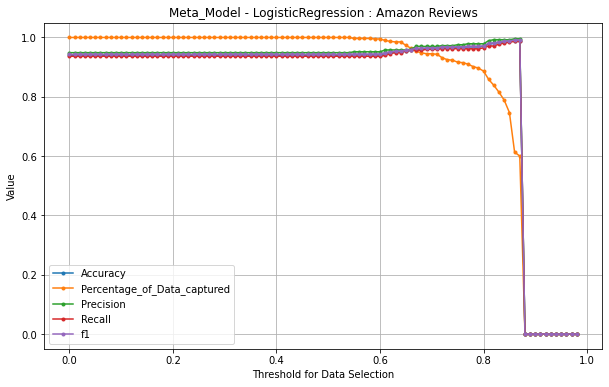

In [148]:
plt.rcParams['figure.figsize'] = [10, 6]
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Accuracy'], marker='.', label='Accuracy')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Percent_data_capture'], marker='.', label='Percentage_of_Data_captured')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Precision'], marker='.', label='Precision')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Recall'], marker='.', label='Recall')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['f1'], marker='.', label='f1')
pyplot.xlabel('Threshold for Data Selection')
pyplot.ylabel('Value')
pyplot.grid(visible=True, which='both', axis='both')
#pyplot.grid(True)
pyplot.title('Meta_Model - LogisticRegression : Amazon Reviews')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()  # we find that doe data selection threshold of 0.78 we should have good results; tradeoof is that we would miss 65% of dta and look at only 35% of data points for an assured accuracy of 90% and f1 score of approx .8

In [77]:
np.unique(y_train,return_counts = True)  # we realise that the dataset is not balanced

(array([-1,  1]), array([702, 698]))

### We look at Precision Recall curve which is more promising since this dataset is imbalanced.

https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0118432

In [78]:
probsdf.head() # vector containing predicted prob for +1

,0,1,trth,label_pol_pred
0,0.023532,0.976468,1,1
1,0.044228,0.955772,1,1
2,0.024322,0.975678,1,1
3,0.020310,0.979690,1,1
4,0.942476,0.057524,-1,-1


In [79]:
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y_train, probsdf[1])


In [80]:
auc_pr = sklearn.metrics.auc(recall,precision)
auc_pr

0.9738261119134756

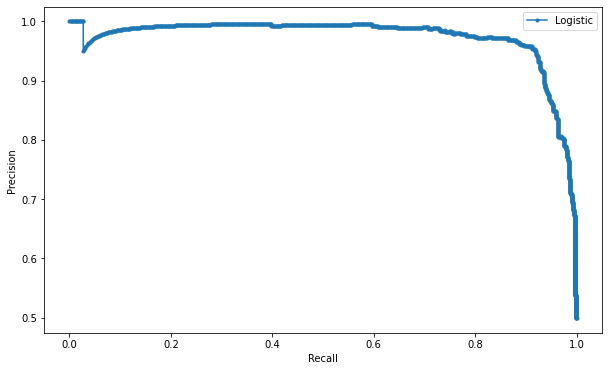

In [81]:
pyplot.plot(recall, precision, marker='.', label='Logistic')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Model Test

In [82]:
#we now test the logistic regressor
X_test.shape

(600, 4)

In [83]:
predictions_test = logmodel.predict(X_test)
probs_test = logmodel.predict_proba(X_test)

Logistic: ROC AUC=0.972


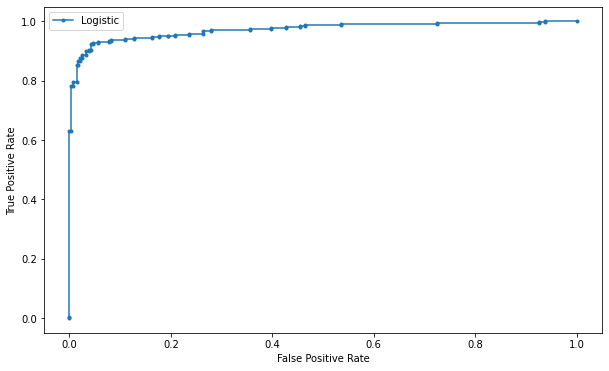

In [84]:
lr_probs = probs_test[:,[1]]
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores

print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves

lr_fpr, lr_tpr, thr = roc_curve(y_test, lr_probs)
# plot the roc curve for the model # pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [85]:
optimal_idx = np.argmax(lr_tpr - lr_fpr) #we need to maximise TP-FP
thr[optimal_idx]

0.44732109780428814

In [86]:
alpha_thresh = thr[optimal_idx]

def label_pol (prob_score):
    
    if prob_score[1] > alpha_thresh:
        return 1
    else:
       return -1

In [87]:
probsdf_test = pd.DataFrame(probs_test)
probsdf_test['trth'] = y_test.to_numpy()
probsdf_test['label_pol_pred'] = probsdf_test.apply (lambda row: label_pol(row), axis=1)
probsdf_test.head()


,0,1,trth,label_pol_pred
0,0.026807,0.973193,1,1
1,0.023811,0.976189,1,1
2,0.023394,0.976606,1,1
3,0.022840,0.977160,1,1
4,0.941055,0.058945,-1,-1


In [88]:
print(pd.DataFrame(metrics.classification_report(probsdf_test['trth'],probsdf_test['label_pol_pred'],output_dict=True)))

                   -1           1  accuracy   macro avg  weighted avg
precision    0.915825    0.960396  0.938333    0.938110      0.939299
recall       0.957746    0.920886  0.938333    0.939316      0.938333
f1-score     0.936317    0.940226  0.938333    0.938271      0.938376
support    284.000000  316.000000  0.938333  600.000000    600.000000


In [89]:
probsdf_test[['trth','label_pol_pred']].corr()

,trth,label_pol_pred
trth,1.000000,0.877426
label_pol_pred,0.877426,1.000000


In [90]:
alpha_th_test = .7
probsdf_test['trth'][(probsdf_test[1]>alpha_th_test)|(probsdf_test[0]>alpha_th_test)].count()

572

In [91]:
print(pd.DataFrame(metrics.classification_report(probsdf_test['trth'][(probsdf_test[1]>alpha_th_test)|(probsdf_test[0]>alpha_th_test) ],probsdf_test['label_pol_pred'][(probsdf_test[1]>alpha_th_test)|(probsdf_test[0]>alpha_th_test)],output_dict=True)))

                   -1           1  accuracy   macro avg  weighted avg
precision    0.928315    0.969283  0.949301    0.948799      0.950089
recall       0.966418    0.934211  0.949301    0.950314      0.949301
f1-score     0.946984    0.951424  0.949301    0.949204      0.949343
support    268.000000  304.000000  0.949301  572.000000    572.000000


In [92]:
probsdf_test['trth'][(probsdf_test[1]>alpha_th)|(probsdf_test[0]>alpha_th)].count()/probsdf_test['trth'].count()

0.8016666666666666

In [93]:
test_results=pd.DataFrame({'Prob':[],'label_pol_predict':[]})
test_results['Prob'] = probsdf_test[1]
test_results['label_pol_pred'] = probsdf_test['label_pol_pred']

### We need to analyse sentences
#### Also we need to compare with the four Base Models /  Tools

In [94]:
result_base_tools_tb = pd.DataFrame(metrics.classification_report(X_test_full['Sentiment'],X_test_full['textblob_polarity'],output_dict=True))

In [95]:
result_base_tools_vader = pd.DataFrame(metrics.classification_report(X_test_full['Sentiment'],X_test_full['vader_polarity'],output_dict=True))

In [96]:
result_base_tools_bert = pd.DataFrame(metrics.classification_report(X_test_full['Sentiment'],X_test_full['bert_polarity'],output_dict=True))

In [97]:
result_base_tools_flair = pd.DataFrame(metrics.classification_report(X_test_full['Sentiment'],X_test_full['flair_polarity'],output_dict=True))

In [98]:
result_base_tools_tb

,-1,1,accuracy,macro avg,weighted avg
precision,0.844262,0.621339,0.666667,0.732801,0.726856
recall,0.362676,0.939873,0.666667,0.651275,0.666667
f1-score,0.507389,0.748111,0.666667,0.627750,0.634169
support,284.000000,316.000000,0.666667,600.000000,600.000000


In [99]:
result_base_tools_vader

,-1,1,accuracy,macro avg,weighted avg
precision,0.849057,0.662132,0.711667,0.755594,0.750609
recall,0.475352,0.924051,0.711667,0.699701,0.711667
f1-score,0.609481,0.771466,0.711667,0.690474,0.694793
support,284.000000,316.000000,0.711667,600.000000,600.000000


In [100]:
result_base_tools_bert

,-1,1,accuracy,macro avg,weighted avg
precision,0.918103,0.807065,0.85,0.862584,0.859623
recall,0.750000,0.939873,0.85,0.844937,0.850000
f1-score,0.825581,0.868421,0.85,0.847001,0.848144
support,284.000000,316.000000,0.85,600.000000,600.000000


In [101]:
result_base_tools_flair

,-1,1,accuracy,macro avg,weighted avg
precision,0.897690,0.959596,0.928333,0.928643,0.930294
recall,0.957746,0.901899,0.928333,0.929823,0.928333
f1-score,0.926746,0.929853,0.928333,0.928300,0.928383
support,284.000000,316.000000,0.928333,600.000000,600.000000


In [102]:
probsdf_test[['tb','vader','bert','flair','textblob_polarity','vader_polarity','bert_polarity','flair_polarity'	]] = X_test_full[['vader','vader','bert','flair','textblob_polarity','vader_polarity','bert_polarity','flair_polarity']].to_numpy()

In [103]:
probsdf_test

,0,1,trth,label_pol_pred,tb,vader,bert,flair,textblob_polarity,vader_polarity,bert_polarity,flair_polarity
0,0.026807,0.973193,1,1,0.8983,0.8983,0.883419,0.999508,1.0,1.0,1.0,1.0
1,0.023811,0.976189,1,1,0.8462,0.8462,0.958900,0.999885,1.0,1.0,1.0,1.0
2,0.023394,0.976606,1,1,0.8620,0.8620,0.942564,0.998770,1.0,1.0,1.0,1.0
3,0.022840,0.977160,1,1,0.8689,0.8689,0.901197,0.999877,1.0,1.0,1.0,1.0
4,0.941055,0.058945,-1,-1,0.9245,0.9245,-0.648101,-0.999966,1.0,1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.024086,0.975914,1,1,0.6808,0.6808,0.950877,0.996381,1.0,1.0,1.0,1.0
596,0.941397,0.058603,-1,-1,-0.2500,-0.2500,-0.602714,-0.999997,1.0,-1.0,-1.0,-1.0
597,0.025978,0.974022,1,1,0.7640,0.7640,0.940615,0.999871,1.0,1.0,1.0,1.0
598,0.797625,0.202375,1,-1,0.7906,0.7906,0.000000,-0.849488,1.0,1.0,1.0,-1.0


In [104]:
abs(probsdf_test['vader']).describe()

count    600.000000
mean       0.672405
std        0.283001
min        0.000000
25%        0.492700
50%        0.761200
75%        0.919575
max        0.995600
Name: vader, dtype: float64

In [105]:
alpha_th_test = .48
pd.DataFrame(metrics.classification_report(probsdf_test['trth'][abs(probsdf_test['vader'])>alpha_th_test],probsdf_test['vader_polarity'][abs(probsdf_test['vader'])>alpha_th_test],output_dict=True))

,-1,1,accuracy,macro avg,weighted avg
precision,0.878788,0.732394,0.764317,0.805591,0.791081
recall,0.478022,0.955882,0.764317,0.716952,0.764317
f1-score,0.619217,0.829346,0.764317,0.724282,0.745109
support,182.000000,272.000000,0.764317,454.000000,454.000000


In [106]:
abs(probsdf_test['bert']).describe()

count    600.000000
mean       0.739844
std        0.289511
min        0.000000
25%        0.643885
50%        0.860355
75%        0.945177
max        0.989440
Name: bert, dtype: float64

In [107]:
alpha_th_test = .78
res2 =pd.DataFrame(metrics.classification_report(probsdf_test['trth'][abs(probsdf_test['bert'])>alpha_th_test],probsdf_test['label_pol_pred'][abs(probsdf_test['bert'])>alpha_th_test],output_dict=True))
res2

,-1,1,accuracy,macro avg,weighted avg
precision,0.972789,0.982609,0.97878,0.977699,0.97878
recall,0.972789,0.982609,0.97878,0.977699,0.97878
f1-score,0.972789,0.982609,0.97878,0.977699,0.97878
support,147.000000,230.000000,0.97878,377.000000,377.00000


In [108]:
try:
    res2['1']
except KeyError:
    0

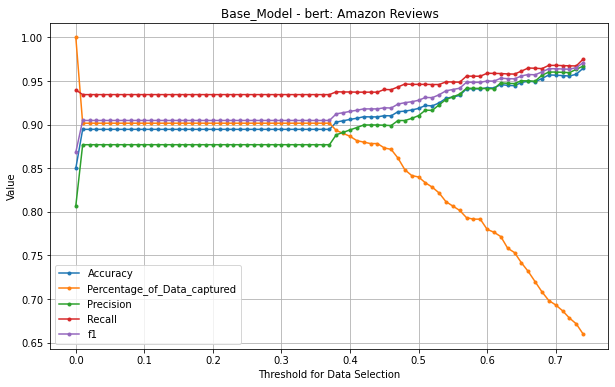

In [109]:
threshold_analysis = pd.DataFrame({'Thresh_alpha':[0],'Accuracy':[0],'Percent_data_capture':[0],'Precision':[0],'Recall':[0],'f1':[0]})
detl_threshold = pd.DataFrame({'Thresh_alpha':[],'Accuracy':[],'Percent_data_capture':[],'Precision':[],'Recall':[],'f1':[]})
for i in range (0,75):
    alpha_th = i*.01
    res1 = pd.DataFrame(classification_report(probsdf_test['trth'][abs(probsdf_test['bert'])>=alpha_th],probsdf_test['bert_polarity'][abs(probsdf_test['bert'])>=alpha_th],output_dict=True))
    threshold_analysis['Accuracy']= res1['accuracy'].loc['precision']
    threshold_analysis['Percent_data_capture'] =  probsdf_test['trth'][abs(probsdf_test['bert'])>=alpha_th].count()/probsdf_test['trth'].count() if  probsdf_test['trth'].count()>0 else 0
    threshold_analysis['Thresh_alpha'] = alpha_th
    try:
        threshold_analysis['Precision'] = res1['1'].loc['precision']
    except KeyError:
        threshold_analysis['Precision']=0
    try:
        threshold_analysis['Recall'] = res1['1'].loc['recall']
    except KeyError:
       threshold_analysis['Recall'] =0
    try:
        threshold_analysis['f1'] = res1['1'].loc['f1-score']
    except KeyError:
        threshold_analysis['f1'] 
    detl_threshold = detl_threshold.append(threshold_analysis)

plt.rcParams['figure.figsize'] = [10, 6]
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Accuracy'], marker='.', label='Accuracy')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Percent_data_capture'], marker='.', label='Percentage_of_Data_captured')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Precision'], marker='.', label='Precision')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Recall'], marker='.', label='Recall')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['f1'], marker='.', label='f1')
pyplot.xlabel('Threshold for Data Selection')
pyplot.ylabel('Value')
pyplot.grid(visible=True, which='both', axis='both')
#pyplot.grid(True)
pyplot.title('Base_Model - bert: Amazon Reviews')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

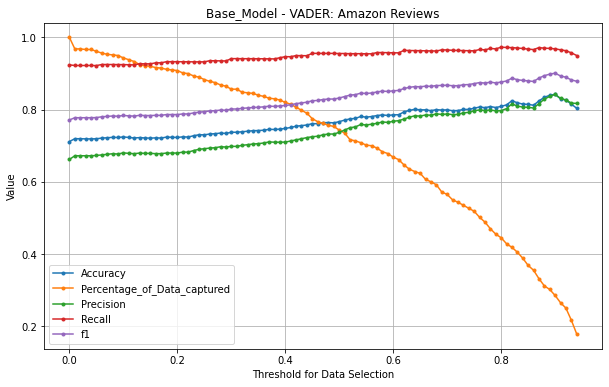

In [110]:
threshold_analysis = pd.DataFrame({'Thresh_alpha':[0],'Accuracy':[0],'Percent_data_capture':[0],'Precision':[0],'Recall':[0],'f1':[0]})
detl_threshold = pd.DataFrame({'Thresh_alpha':[],'Accuracy':[],'Percent_data_capture':[],'Precision':[],'Recall':[],'f1':[]})
for i in range (0,95):
    alpha_th = i*.01
    res1 = pd.DataFrame(classification_report(probsdf_test['trth'][abs(probsdf_test['vader'])>=alpha_th],probsdf_test['vader_polarity'][abs(probsdf_test['vader'])>=alpha_th],output_dict=True))
    threshold_analysis['Accuracy']= res1['accuracy'].iloc[0]
    threshold_analysis['Percent_data_capture'] = probsdf_test['trth'][abs(probsdf_test['vader'])>=alpha_th].count()/probsdf_test['trth'].count()
    threshold_analysis['Thresh_alpha'] = alpha_th
    try:
        threshold_analysis['Precision'] = res1['1'].loc['precision']
        threshold_analysis['Recall'] = res1['1'].loc['recall']
        threshold_analysis['f1'] = res1['1'].loc['f1-score']
    except KeyError:
        threshold_analysis['Precision'] = 0
        threshold_analysis['Recall'] = 0
        threshold_analysis['f1'] = 0
    detl_threshold = detl_threshold.append(threshold_analysis)

plt.rcParams['figure.figsize'] = [10, 6]
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Accuracy'], marker='.', label='Accuracy')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Percent_data_capture'], marker='.', label='Percentage_of_Data_captured')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Precision'], marker='.', label='Precision')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Recall'], marker='.', label='Recall')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['f1'], marker='.', label='f1')
pyplot.xlabel('Threshold for Data Selection')
pyplot.ylabel('Value')
pyplot.grid(visible=True, which='both', axis='both')
#pyplot.grid(True)
pyplot.title('Base_Model - VADER: Amazon Reviews')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

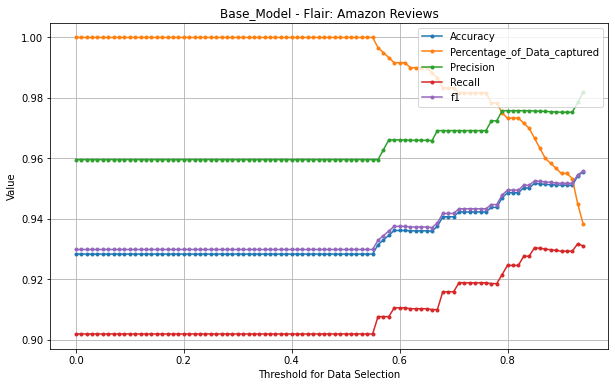

In [111]:
threshold_analysis = pd.DataFrame({'Thresh_alpha':[0],'Accuracy':[0],'Percent_data_capture':[0],'Precision':[0],'Recall':[0],'f1':[0]})
detl_threshold = pd.DataFrame({'Thresh_alpha':[],'Accuracy':[],'Percent_data_capture':[],'Precision':[],'Recall':[],'f1':[]})
for i in range (0,95):
    alpha_th = i*.01
    res1 = pd.DataFrame(classification_report(probsdf_test['trth'][abs(probsdf_test['flair'])>=alpha_th],probsdf_test['flair_polarity'][abs(probsdf_test['flair'])>=alpha_th],output_dict=True))
    threshold_analysis['Accuracy']= res1['accuracy'].iloc[0]
    threshold_analysis['Percent_data_capture'] = probsdf_test['trth'][abs(probsdf_test['flair'])>=alpha_th].count()/probsdf_test['trth'].count()
    threshold_analysis['Thresh_alpha'] = alpha_th
    try:
        threshold_analysis['Precision'] = res1['1'].loc['precision']
        threshold_analysis['Recall'] = res1['1'].loc['recall']
        threshold_analysis['f1'] = res1['1'].loc['f1-score']
    except KeyError:
        threshold_analysis['Precision'] = 0
        threshold_analysis['Recall'] = 0
        threshold_analysis['f1'] = 0
    detl_threshold = detl_threshold.append(threshold_analysis)

plt.rcParams['figure.figsize'] = [10, 6]
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Accuracy'], marker='.', label='Accuracy')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Percent_data_capture'], marker='.', label='Percentage_of_Data_captured')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Precision'], marker='.', label='Precision')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Recall'], marker='.', label='Recall')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['f1'], marker='.', label='f1')
pyplot.xlabel('Threshold for Data Selection')
pyplot.ylabel('Value')
pyplot.grid(visible=True, which='both', axis='both')
#pyplot.grid(True)
pyplot.title('Base_Model - Flair: Amazon Reviews')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

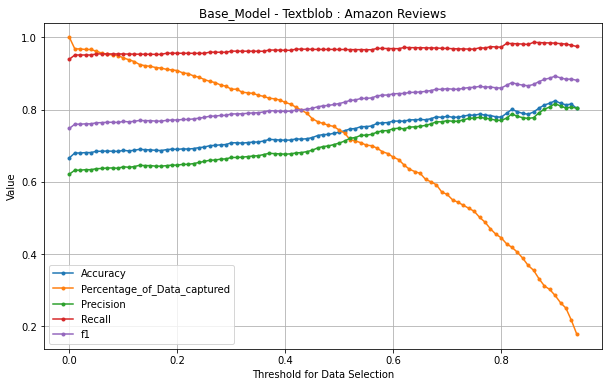

In [112]:
threshold_analysis = pd.DataFrame({'Thresh_alpha':[0],'Accuracy':[0],'Percent_data_capture':[0],'Precision':[0],'Recall':[0],'f1':[0]})
detl_threshold = pd.DataFrame({'Thresh_alpha':[],'Accuracy':[],'Percent_data_capture':[],'Precision':[],'Recall':[],'f1':[]})
for i in range (0,95):
    alpha_th = i*.01
    res1 = pd.DataFrame(classification_report(probsdf_test['trth'][abs(probsdf_test['tb'])>=alpha_th],probsdf_test['textblob_polarity'][abs(probsdf_test['tb'])>=alpha_th],output_dict=True))
    threshold_analysis['Accuracy']= res1['accuracy'].iloc[0]
    threshold_analysis['Percent_data_capture'] = probsdf_test['trth'][abs(probsdf_test['tb'])>=alpha_th].count()/probsdf_test['trth'].count()
    threshold_analysis['Thresh_alpha'] = alpha_th
    try:
        threshold_analysis['Precision'] = res1['1'].loc['precision']
        threshold_analysis['Recall'] = res1['1'].loc['recall']
        threshold_analysis['f1'] = res1['1'].loc['f1-score']
    except KeyError:
        threshold_analysis['Precision'] = 0
        threshold_analysis['Recall'] = 0
        threshold_analysis['f1'] = 0
    detl_threshold = detl_threshold.append(threshold_analysis)

plt.rcParams['figure.figsize'] = [10, 6]
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Accuracy'], marker='.', label='Accuracy')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Percent_data_capture'], marker='.', label='Percentage_of_Data_captured')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Precision'], marker='.', label='Precision')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Recall'], marker='.', label='Recall')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['f1'], marker='.', label='f1')
pyplot.xlabel('Threshold for Data Selection')
pyplot.ylabel('Value')
pyplot.grid(visible=True, which='both', axis='both')
#pyplot.grid(True)
pyplot.title('Base_Model - Textblob : Amazon Reviews')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [113]:
probsdf_test

,0,1,trth,label_pol_pred,tb,vader,bert,flair,textblob_polarity,vader_polarity,bert_polarity,flair_polarity
0,0.026807,0.973193,1,1,0.8983,0.8983,0.883419,0.999508,1.0,1.0,1.0,1.0
1,0.023811,0.976189,1,1,0.8462,0.8462,0.958900,0.999885,1.0,1.0,1.0,1.0
2,0.023394,0.976606,1,1,0.8620,0.8620,0.942564,0.998770,1.0,1.0,1.0,1.0
3,0.022840,0.977160,1,1,0.8689,0.8689,0.901197,0.999877,1.0,1.0,1.0,1.0
4,0.941055,0.058945,-1,-1,0.9245,0.9245,-0.648101,-0.999966,1.0,1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.024086,0.975914,1,1,0.6808,0.6808,0.950877,0.996381,1.0,1.0,1.0,1.0
596,0.941397,0.058603,-1,-1,-0.2500,-0.2500,-0.602714,-0.999997,1.0,-1.0,-1.0,-1.0
597,0.025978,0.974022,1,1,0.7640,0.7640,0.940615,0.999871,1.0,1.0,1.0,1.0
598,0.797625,0.202375,1,-1,0.7906,0.7906,0.000000,-0.849488,1.0,1.0,1.0,-1.0


In [114]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

In [115]:


# List of classifiers to evaluate
classifiers = [
    ('Logistic Regression', LogisticRegression()),
    ('Support Vector Machine', SVC()),
    ('Random Forest', RandomForestClassifier()),
    ('Naive Bayes', GaussianNB())
]

# Iterate over classifiers and evaluate using cross-validation
for name, classifier in classifiers:
    scores = cross_val_score(classifier, X_train, y_train, cv=5)
    mean_score = np.mean(scores)
    print(f"{name} Mean Accuracy: {mean_score:.4f}")

# Choose the best model based on cross-validation scores
best_classifier = max(classifiers, key=lambda x: np.mean(cross_val_score(x[1], X_train, y_train, cv=5)))[1]

# Train the best classifier on the full training set
best_classifier.fit(X_train, y_train)

# Test the model on the test set
y_pred = best_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Best Model Test Accuracy: {accuracy:.4f}")


Logistic Regression Mean Accuracy: 0.9307
Support Vector Machine Mean Accuracy: 0.9279
Random Forest Mean Accuracy: 0.9421
Naive Bayes Mean Accuracy: 0.9271
Best Model Test Accuracy: 0.9383


In [116]:
model_eval = pd.DataFrame({'Model':[],'Mean_Score':[]})

In [117]:
model_eval

,Model,Mean_Score


In [118]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
model_eval = pd.DataFrame({'Model':[],'Mean_Score':[]})

# List of classifiers to evaluate
classifiers = [
    ('Logistic Regression', LogisticRegression()),
    ('Support Vector Machine', SVC()),
    ('Random Forest', RandomForestClassifier()),
    ('Naive Bayes', GaussianNB()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('AdaBoost', AdaBoostClassifier()),
    ('Ridge Classifier', RidgeClassifier())
]

# Iterate over classifiers and evaluate using cross-validation
for name, classifier in classifiers:
    scores = cross_val_score(classifier, X_train, y_train, cv=5)
    mean_score = np.mean(scores)
    scores_temp = pd.DataFrame({'Model':[name],'Mean_Score':[mean_score]})
    model_eval = model_eval.append(scores_temp)
    print(f"{name} Mean Accuracy: {mean_score:.4f}")

# Choose the best model based on cross-validation scores
best_classifier = max(classifiers, key=lambda x: np.mean(cross_val_score(x[1], X_train, y_train, cv=5)))[1]

# Train the best classifier on the full training set
best_classifier.fit(X_train, y_train)

# Test the model on the test set
y_pred = best_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Best Model Test Accuracy: {accuracy:.4f}")


Logistic Regression Mean Accuracy: 0.9307
Support Vector Machine Mean Accuracy: 0.9279
Random Forest Mean Accuracy: 0.9400
Naive Bayes Mean Accuracy: 0.9271
Decision Tree Mean Accuracy: 0.9057
Gradient Boosting Mean Accuracy: 0.9329
AdaBoost Mean Accuracy: 0.9314
Ridge Classifier Mean Accuracy: 0.9279
Best Model Test Accuracy: 0.9367


In [149]:
model_eval

,Model,Mean_Score
0,Logistic Regression,0.930714
0,Support Vector Machine,0.927857
0,Random Forest,0.940000
0,Naive Bayes,0.927143
0,Decision Tree,0.905714
0,Gradient Boosting,0.932857
0,AdaBoost,0.931429
0,Ridge Classifier,0.927857


In [120]:
model_eval.to_csv('amazon_model_eval.csv')

In [121]:
best_classifier

RandomForestClassifier()

In [122]:

gb_classifier = GradientBoostingClassifier(n_estimators=150, learning_rate=0.01,random_state=42)
# Train the classifier on the training data
gb_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = gb_classifier.predict(X_test)

# Evaluate the classifier's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))




Accuracy: 0.94
Classification Report:
              precision    recall  f1-score   support

          -1       0.93      0.94      0.94       284
           1       0.95      0.94      0.94       316

    accuracy                           0.94       600
   macro avg       0.94      0.94      0.94       600
weighted avg       0.94      0.94      0.94       600



In [123]:
y_probs = gb_classifier.predict_proba(X_train)
y_probs.shape

(1400, 2)

Logistic: ROC AUC=0.988


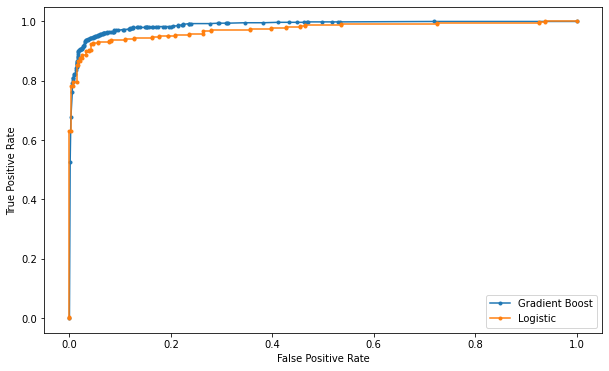

In [124]:
gb_probs = y_probs[:,[1]]
gb_auc = roc_auc_score(y_train, gb_probs)
# summarize scores

print('Logistic: ROC AUC=%.3f' % (gb_auc))
# calculate roc curves

gb_fpr, gb_tpr, thr = roc_curve(y_train, gb_probs)
# plot the roc curve for the model # pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(gb_fpr, gb_tpr, marker='.', label='Gradient Boost')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Logistic: ROC AUC=0.974


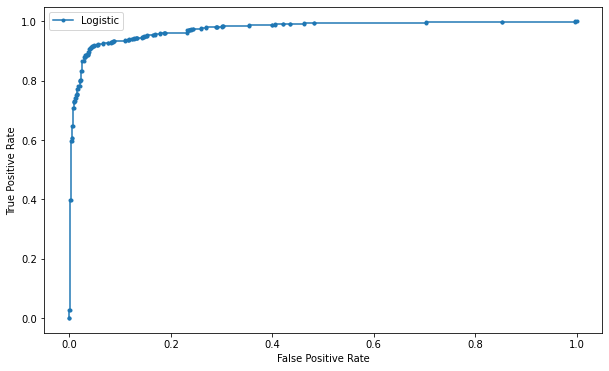

In [125]:
lr_probs = probs[:,[1]]
lr_auc = roc_auc_score(y_train, lr_probs)
# summarize scores

print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves

lr_fpr, lr_tpr, thr = roc_curve(y_train, lr_probs)
# plot the roc curve for the model # pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [126]:
y_probs = gb_classifier.predict_proba(X_test)

Logistic: ROC AUC=0.982


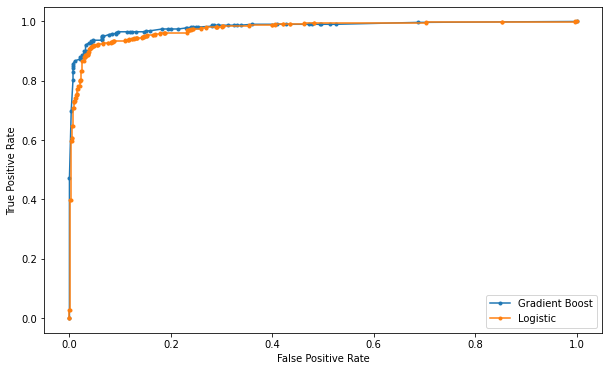

In [127]:
gb_probs = y_probs[:,[1]]
gb_auc = roc_auc_score(y_test, gb_probs)
# summarize scores

print('Logistic: ROC AUC=%.3f' % (gb_auc))
# calculate roc curves

gb_fpr, gb_tpr, thr = roc_curve(y_test, gb_probs)
# plot the roc curve for the model # pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(gb_fpr, gb_tpr, marker='.', label='Gradient Boost')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [128]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

gb_classifier1 = GradientBoostingClassifier()

# Define a grid of hyperparameters to search
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.1, 0.01],
    'max_depth': [3, 4, 5]
}

# Initialize GridSearchCV with the classifier and parameter grid
grid_search = GridSearchCV(gb_classifier1, param_grid, cv=3, scoring='accuracy')

# Perform hyperparameter tuning on the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Use the best model for prediction
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the classifier's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Accuracy: 0.94
Classification Report:
              precision    recall  f1-score   support

          -1       0.93      0.94      0.94       284
           1       0.95      0.94      0.94       316

    accuracy                           0.94       600
   macro avg       0.94      0.94      0.94       600
weighted avg       0.94      0.94      0.94       600



# Best Model Analysis
The best meta model was found to be GradientBoost. here after hyperparameter tuning we found the accuracy score to be 0.73
Now we will see if we can custom threshold and improve acuraccy.

In [129]:
probsdf_test['GBprobs_0']=gb_classifier.predict_proba(X_test)[:,0]
probsdf_test['GBprobs_1']=gb_classifier.predict_proba(X_test)[:,1]
probsdf_test.head()

,0,1,trth,label_pol_pred,tb,vader,bert,flair,textblob_polarity,vader_polarity,bert_polarity,flair_polarity,GBprobs_0,GBprobs_1
0,0.026807,0.973193,1,1,0.8983,0.8983,0.883419,0.999508,1.0,1.0,1.0,1.0,0.124467,0.875533
1,0.023811,0.976189,1,1,0.8462,0.8462,0.958900,0.999885,1.0,1.0,1.0,1.0,0.124467,0.875533
2,0.023394,0.976606,1,1,0.8620,0.8620,0.942564,0.998770,1.0,1.0,1.0,1.0,0.124467,0.875533
3,0.022840,0.977160,1,1,0.8689,0.8689,0.901197,0.999877,1.0,1.0,1.0,1.0,0.124467,0.875533
4,0.941055,0.058945,-1,-1,0.9245,0.9245,-0.648101,-0.999966,1.0,1.0,-1.0,-1.0,0.856633,0.143367


In [130]:
def Gb_polarity(val):
    if val >= 0.5:
        return 1
    else:
        return -1

In [131]:
probsdf_test['GBoost_polarity']= probsdf_test.apply (lambda x : Gb_polarity(x['GBprobs_1']),axis=1)
probsdf_test['GBoost_Pred']=gb_classifier.predict(X_test)

In [132]:
probsdf_test['trth1']=y_test

In [133]:
probsdf_test.head()

,0,1,trth,label_pol_pred,tb,vader,bert,flair,textblob_polarity,vader_polarity,bert_polarity,flair_polarity,GBprobs_0,GBprobs_1,GBoost_polarity,GBoost_Pred,trth1
0,0.026807,0.973193,1,1,0.8983,0.8983,0.883419,0.999508,1.0,1.0,1.0,1.0,0.124467,0.875533,1,1,NaN
1,0.023811,0.976189,1,1,0.8462,0.8462,0.958900,0.999885,1.0,1.0,1.0,1.0,0.124467,0.875533,1,1,NaN
2,0.023394,0.976606,1,1,0.8620,0.8620,0.942564,0.998770,1.0,1.0,1.0,1.0,0.124467,0.875533,1,1,NaN
3,0.022840,0.977160,1,1,0.8689,0.8689,0.901197,0.999877,1.0,1.0,1.0,1.0,0.124467,0.875533,1,1,NaN
4,0.941055,0.058945,-1,-1,0.9245,0.9245,-0.648101,-0.999966,1.0,1.0,-1.0,-1.0,0.856633,0.143367,-1,-1,1.0


### Stacked Ensemble with Meta Model as LR : Amazon Reviews

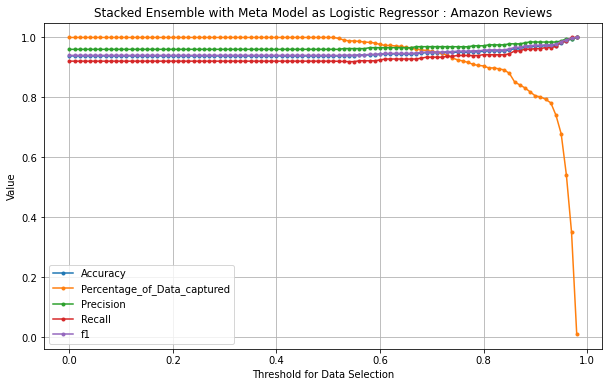

In [134]:

threshold_analysis = pd.DataFrame({'Thresh_alpha':[0],'Accuracy':[0],'Percent_data_capture':[0],'Precision':[0],'Recall':[0],'f1':[0]})
detl_threshold = pd.DataFrame({'Thresh_alpha':[],'Accuracy':[],'Percent_data_capture':[],'Precision':[],'Recall':[],'f1':[]})
for i in range (0,99):
    alpha_th = i*.01
    res1 = pd.DataFrame(classification_report(probsdf_test['trth'][(probsdf_test[0]>=alpha_th)|(probsdf_test[1]>=alpha_th)],probsdf_test['label_pol_pred'][(probsdf_test[0]>=alpha_th)|(probsdf_test[1]>=alpha_th)],output_dict=True))
    threshold_analysis['Accuracy']= res1['accuracy'].iloc[0]
    threshold_analysis['Percent_data_capture'] = probsdf_test['trth'][(probsdf_test[0]>=alpha_th)|(probsdf_test[1]>=alpha_th)].count()/probsdf_test[0].count()
    threshold_analysis['Thresh_alpha'] = alpha_th
    try:
        threshold_analysis['Precision'] = res1['1'].loc['precision']
        threshold_analysis['Recall'] = res1['1'].loc['recall']
        threshold_analysis['f1'] = res1['1'].loc['f1-score']
    except KeyError:
        threshold_analysis['Precision'] = 0
        threshold_analysis['Recall'] = 0
        threshold_analysis['f1'] = 0
    detl_threshold = detl_threshold.append(threshold_analysis)

plt.rcParams['figure.figsize'] = [10, 6]
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Accuracy'], marker='.', label='Accuracy')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Percent_data_capture'], marker='.', label='Percentage_of_Data_captured')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Precision'], marker='.', label='Precision')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Recall'], marker='.', label='Recall')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['f1'], marker='.', label='f1')
pyplot.xlabel('Threshold for Data Selection')
pyplot.ylabel('Value')
pyplot.grid(visible=True, which='both', axis='both')
#pyplot.grid(True)
pyplot.title('Stacked Ensemble with Meta Model as Logistic Regressor : Amazon Reviews')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

### Stacked Ensemble with Meta Model as GradientBoost : Amazon Reviews

/Users/amitobe/opt/anaconda3/envs/nlp_course/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/amitobe/opt/anaconda3/envs/nlp_course/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/amitobe/opt/anaconda3/envs/nlp_course/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/amitobe/opt/anaconda3/envs/nlp_course/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = re

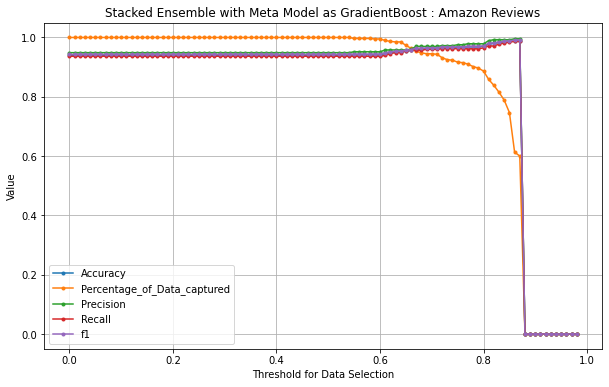

In [135]:
threshold_analysis = pd.DataFrame({'Thresh_alpha':[0],'Accuracy':[0],'Percent_data_capture':[0],'Precision':[0],'Recall':[0],'f1':[0]})
detl_threshold = pd.DataFrame({'Thresh_alpha':[],'Accuracy':[],'Percent_data_capture':[],'Precision':[],'Recall':[],'f1':[]})
for i in range (0,99):
    alpha_th = i*.01
    res1 = pd.DataFrame(classification_report(probsdf_test['trth'][(probsdf_test['GBprobs_1']>alpha_th) | (probsdf_test['GBprobs_0']>alpha_th)],probsdf_test['GBoost_Pred'][(probsdf_test['GBprobs_1']>alpha_th) | (probsdf_test['GBprobs_0']>alpha_th)],output_dict=True))
    threshold_analysis['Accuracy']= res1['accuracy'].iloc[0]
    threshold_analysis['Percent_data_capture'] = probsdf_test['trth'][(probsdf_test['GBprobs_1']>alpha_th) | (probsdf_test['GBprobs_0']>alpha_th)].count()/probsdf_test['GBprobs_1'].count()
    threshold_analysis['Thresh_alpha'] = alpha_th
    try:
        threshold_analysis['Precision'] = res1['1'].loc['precision']
        threshold_analysis['Recall'] = res1['1'].loc['recall']
        threshold_analysis['f1'] = res1['1'].loc['f1-score']
    except KeyError:
        threshold_analysis['Precision'] = 0
        threshold_analysis['Recall'] = 0
        threshold_analysis['f1'] = 0
    detl_threshold = detl_threshold.append(threshold_analysis)

plt.rcParams['figure.figsize'] = [10, 6]
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Accuracy'], marker='.', label='Accuracy')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Percent_data_capture'], marker='.', label='Percentage_of_Data_captured')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Precision'], marker='.', label='Precision')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['Recall'], marker='.', label='Recall')
pyplot.plot(detl_threshold['Thresh_alpha'], detl_threshold['f1'], marker='.', label='f1')
pyplot.xlabel('Threshold for Data Selection')
pyplot.ylabel('Value')
pyplot.grid(visible=True, which='both', axis='both')
#pyplot.grid(True)
pyplot.title('Stacked Ensemble with Meta Model as GradientBoost : Amazon Reviews')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [136]:
corr_analysis = probsdf_test[['label_pol_pred','GBoost_Pred','textblob_polarity','flair_polarity','vader_polarity','bert_polarity','trth']].corr()

In [137]:
probsdf_test[['label_pol_pred','GBoost_Pred','textblob_polarity','flair_polarity','vader_polarity','bert_polarity','trth']].corr().to_csv('final_corrdata_amazon.csv')

(array([271.,  17.,   5.,   1.,   6.,   6.,  13.,  25.,  36., 220.]),
 array([0.01710704, 0.11302222, 0.2089374 , 0.30485258, 0.40076776,
        0.49668294, 0.59259812, 0.6885133 , 0.78442848, 0.88034366,
        0.97625884]),
 <a list of 10 Patch objects>)

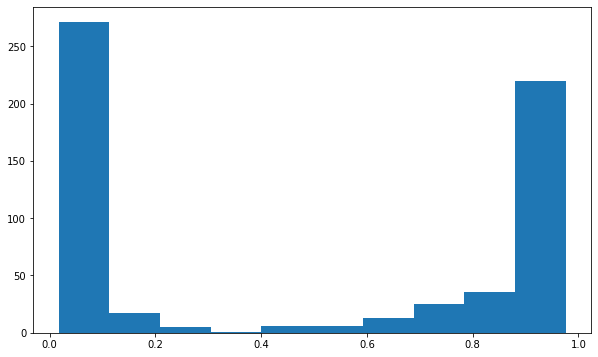

In [138]:
plt.hist(probsdf_test[0])

(array([282.,   7.,  19.,   3.,   1.,   1.,  11.,  10.,  16., 250.]),
 array([0.12446741, 0.1994513 , 0.2744352 , 0.34941909, 0.42440299,
        0.49938689, 0.57437078, 0.64935468, 0.72433857, 0.79932247,
        0.87430636]),
 <a list of 10 Patch objects>)

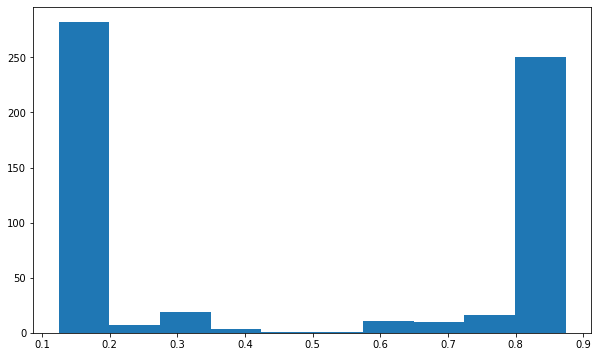

In [139]:
plt.hist(probsdf_test['GBprobs_0'])

In [140]:
dat = corr_analysis['trth'].to_numpy()

In [141]:
zz = corr_analysis.index

In [142]:
zz.to_list()

['label_pol_pred',
 'GBoost_Pred',
 'textblob_polarity',
 'flair_polarity',
 'vader_polarity',
 'bert_polarity',
 'trth']

In [143]:
dat

array([0.87742593, 0.879822  , 0.37532306, 0.85846466, 0.45185168,
       0.70730092, 1.        ])

# Final Analysis LR vs GBoost

In [144]:
alpha_th_test = 0
pd.DataFrame(metrics.classification_report(probsdf_test['trth'][(probsdf_test['GBprobs_1']>alpha_th_test) | (probsdf_test['GBprobs_0']>alpha_th_test)],probsdf_test['GBoost_Pred'][(probsdf_test['GBprobs_1']>alpha_th_test) | (probsdf_test['GBprobs_0']>alpha_th_test)],output_dict=True))

,-1,1,accuracy,macro avg,weighted avg
precision,0.930556,0.948718,0.94,0.939637,0.940121
recall,0.943662,0.936709,0.94,0.940185,0.940000
f1-score,0.937063,0.942675,0.94,0.939869,0.940019
support,284.000000,316.000000,0.94,600.000000,600.000000


In [145]:
alpha_th_test = 0
pd.DataFrame(metrics.classification_report(probsdf_test['trth'][(probsdf_test[0]>alpha_th_test) | (probsdf_test[1]>alpha_th_test)],probsdf_test['label_pol_pred'][(probsdf_test[0]>alpha_th_test) | (probsdf_test[1]>alpha_th_test)],output_dict=True))

,-1,1,accuracy,macro avg,weighted avg
precision,0.915825,0.960396,0.938333,0.938110,0.939299
recall,0.957746,0.920886,0.938333,0.939316,0.938333
f1-score,0.936317,0.940226,0.938333,0.938271,0.938376
support,284.000000,316.000000,0.938333,600.000000,600.000000


In [146]:
probsdf_test.head()

,0,1,trth,label_pol_pred,tb,vader,bert,flair,textblob_polarity,vader_polarity,bert_polarity,flair_polarity,GBprobs_0,GBprobs_1,GBoost_polarity,GBoost_Pred,trth1
0,0.026807,0.973193,1,1,0.8983,0.8983,0.883419,0.999508,1.0,1.0,1.0,1.0,0.124467,0.875533,1,1,NaN
1,0.023811,0.976189,1,1,0.8462,0.8462,0.958900,0.999885,1.0,1.0,1.0,1.0,0.124467,0.875533,1,1,NaN
2,0.023394,0.976606,1,1,0.8620,0.8620,0.942564,0.998770,1.0,1.0,1.0,1.0,0.124467,0.875533,1,1,NaN
3,0.022840,0.977160,1,1,0.8689,0.8689,0.901197,0.999877,1.0,1.0,1.0,1.0,0.124467,0.875533,1,1,NaN
4,0.941055,0.058945,-1,-1,0.9245,0.9245,-0.648101,-0.999966,1.0,1.0,-1.0,-1.0,0.856633,0.143367,-1,-1,1.0


In [147]:
amazon_vader_acc = pd.DataFrame(metrics.classification_report(newsheadline_corr_analysis['Sentiment'], newsheadline_corr_analysis['vader_polarity'],output_dict=True))
amazon_tb_acc = pd.DataFrame(metrics.classification_report(newsheadline_corr_analysis['Sentiment'], newsheadline_corr_analysis['textblob_polarity'],output_dict=True))
amazon_bert_acc = pd.DataFrame(metrics.classification_report(newsheadline_corr_analysis['Sentiment'], newsheadline_corr_analysis['bert_polarity'],output_dict=True))
amazon_flair_acc = pd.DataFrame(metrics.classification_report(newsheadline_corr_analysis['Sentiment'], newsheadline_corr_analysis['flair_polarity'],output_dict=True))

alpha_th_test = 0
amazon_gboost_acc = pd.DataFrame(metrics.classification_report(probsdf_test['trth'][(probsdf_test['GBprobs_1']>alpha_th_test) | (probsdf_test['GBprobs_0']>alpha_th_test)],probsdf_test['GBoost_Pred'][(probsdf_test['GBprobs_1']>alpha_th_test) | (probsdf_test['GBprobs_0']>alpha_th_test)],output_dict=True))
amazon_LR_acc = pd.DataFrame(metrics.classification_report(probsdf_test['trth'][(probsdf_test[0]>alpha_th_test) | (probsdf_test[1]>alpha_th_test)],probsdf_test['label_pol_pred'][(probsdf_test[0]>alpha_th_test) | (probsdf_test[1]>alpha_th_test)],output_dict=True))
amazon_acc_compare = pd.DataFrame({'Dataset':'amazon','Log_reg_meta':[0],'GBoost_meta':[0],'VADER':[0],'TextBlob':[0],'Flair':[0],'BERT':[0]})
amazon_acc_compare['GBoost_meta'].iloc[0]=amazon_gboost_acc['accuracy'].loc['precision']
amazon_acc_compare['Log_reg_meta'].iloc[0]=amazon_LR_acc['accuracy'].loc['precision']
amazon_acc_compare['VADER'].iloc[0]=amazon_vader_acc['accuracy'].loc['precision']
amazon_acc_compare['BERT'].iloc[0]=amazon_bert_acc['accuracy'].loc['precision']
amazon_acc_compare['Flair'].iloc[0]=amazon_flair_acc['accuracy'].loc['precision']
amazon_acc_compare['TextBlob'].iloc[0]=amazon_tb_acc['accuracy'].loc['precision']
amazon_acc_compare.to_csv('amazon_acc_analysis.csv')
amazon_acc_compare

/Users/amitobe/opt/anaconda3/envs/nlp_course/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Dataset,Log_reg_meta,GBoost_meta,VADER,TextBlob,Flair,BERT
0,amazon,0.938333,0.94,0.6885,0.654,0.928,0.8575
